<div style=”text-align: left”> Bachelorarbeit, Lattice Boltzmann Simulation

<img src="pic/ost_logo.jpg" width="300" align="right"/>
<br> FS 2021 
<br>  <a href=mailto:remo.haenggi@hotmail.ch> Student: Remo Hänggi </a> <a href=mailto:christoph.wuersch@ost.ch>
<br>
Advisor: Prof. Dr. Christoph Würsch </a </div>
    
---

# Lattice Boltzmann 2D Channel Flow Simulation mit lbmpy

Dieses Notebook gibt eine kurze Einführung für das [`lbmpy`](https://pycodegen.pages.i10git.cs.fau.de/lbmpy/) Paket des [Walberla Frameworks](https://www.walberla.net).

Lernziele dieses Notebooks:

    - Simulationsszenario mit lbmpy erstellen können
    - Simulationsparameter anpassen und verstehen können
    
Die Rechenzeit kann durch Auslagerung auf die Grafikkarte stark reduziert werden. Dazu werden folgende Pakete benötigt (Stand 01.08.2021):
    
    - CUDA 10.0
    - Python 3.8.8
    - PyStencils 0.3.3
    - lbmpy 0.3.3
    - PyCuda 2020.1
    - VisualStudios 2017
    
Wichtig: CUDA_PATH und die PATH Variable zu VisualStudios 2017 muss gesetzt sein.

In [1]:
# !pip install lbmpy

In [2]:
#optimization = {'target': 'cpu'}
optimization = {'target': 'gpu'}

## Inhaltsverzeichnis:

* [Einleitung](#Einleitung)


* [Parameter](#Parameter)
    * [Länge und Höhe des Kanals](#Länge_und_Höhe_des_Kanals) 
    * [Maximale Geschwindigkeit](#Maximale_Geschwindigkeit)
    * [Relaxation Zeit](#Relaxation_Zeit)
    * [Methode der Simulation](#Methode_der_Simulation)


* [Erste Simulation](#Erste_Simulation)
    * [Parameter Definition](#Parameter_Definition) 
    * [Visualisierung](#Visualisierung)
    * [Simulation](#Simulation)


* [Einfluss der Parameter](#Einfluss_der_Parameter)
    * [Relaxation Zeit](#Relaxation_Zeit_2) 
    * [Methode](#Methode) 
    
    
* [Physikalische Parameter](#Physikalische_Parameter)
    * [Eingabewerte](#Eingabewerte)
    * [Konvertierung](#Konvertierung) 
   
    
* [Hindernisse](#Hindernisse)
    * [Rechteck](#Rechteck) 
    * [Maske](#Maske) 

## Einleitung <a class="anchor" id="Einleitung"></a>

Eine Lattice Boltzmann Simulation kann sehr viele problemspezifische Formen annehmen. Das führt dazu, dass generalisierte und effiziente Implementierungen der LBM (Lattice Boltzmann Methode) sehr schwierig oder sogar nicht möglich sind. Wie kann uns `lbmpy` dabei helfen?

Die Grundfunktion von `lbmpy` ist grundsätzlich sehr leicht zu verstehen. Anhand User spezifizierten Parametern erstellt `lbmpy` einen Code in der Programmiersprache C, welcher die Funktionen der LBM auf die Input-Parameter beschränkt. Diese Parameter können zu sehr komplexen oder sehr simplen Simulationen führen. Der Code wird auch nicht leicht leserlich generiert, sondern so effizient wie möglich. Am Ende wird die von uns initialisierte Simulation auf unsere Bedürfnisse zugeschnitten.

In dieser Reihe von Notebooks werden wir uns auf simple Szenarien beschränken. 

---

## Parameter <a class="anchor" id="Parameter"></a>

Um ein minimales, nicht periodisches Szenario erstellen zu können, müssen wir folgende Parameter definieren.

    o Länge des Kanals
    o Höhe des Kanals
    o Maximale Geschwindigkeit der Luft für den Inletbereich
    o Relaxation Zeit der Luft
    o Methode für die Simulation
    
Diese Werte werden nicht als physikalische Grössen, sondern diskretisiert und einheitenlos übergeben. Wir unterscheiden also zwischen dem *physikalischen Raum* und dem *lattice Raum*. Die Konvertierung zwischen den beiden Räumen wird im Verlauf dieses Notebooks behandelt.

---

### Länge und Höhe des Kanals: <a class="anchor" id="Länge_und_Höhe_des_Kanals"></a>
Definiert die Grösse und Unterteilung des Simulationsraums in *lattice units*. Eine lattice unit entspricht einer Zelle im Raum. Je grösser der Raum (bei gleichbleibender lattice unit), desto besser wird die Auflösung und Genauigkeit der Simulation.

### Maximale Geschwindigkeit: <a class="anchor" id="Maximale_Geschwindigkeit"></a>
Bestimmt die maximale Geschwindigkeit in lattice units. Die Geschwindigkeit wird als parabolische Geschwindigkeitsverteilung am Inlet angelegt. Der Outlet wird dabei auf einen konstanten Druck von einer lattice unit gelegt, um einen Abflusseffekt zu erzielen. 

### Relaxation Zeit: <a class="anchor" id="Relaxionszeit"></a>
Definiert die Relaxation Zeit an jeder Zelle in lattice units. Die Relaxionszeit liegt in einem Zusammenhang mit der Viskosität des Mediums (bei uns Luft).

### Methode der Simulation: <a class="anchor" id="Methode_der_Simulation"></a>
Bestimmt, anhand welcher Methode die Simulation berechnet werden soll. Die [API](https://pycodegen.pages.i10git.cs.fau.de/lbmpy/sphinx/methodcreation.html) von `lbmpy` bietet einen Überblick über alle implementierten Methoden. Wir werden die Methoden *Single Relaxation Time* und *cumulant* verwenden.

&nbsp;&nbsp;&nbsp;**Single Relaxation Time:**
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Die SRT oder auch BGK Methode verwendet für die Kollisionsschrittgleichung eine Relaxation Zeit $\tau$. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$f_i(\bar{x}, t+\delta_{t}) = f_i(\bar{x}, t) + \Large\frac{f_i^{eq}(\bar{x}, t) - f_i(\bar{x}, t)}{\tau}$ 
    
&nbsp;&nbsp;&nbsp;**Cumulant:**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Bei dieser Methode wird der Kollisionsschritt mit [Kumulanten](https://www.sciencedirect.com/science/article/pii/S0898122115002126) berechnet, welche die Abweichung einer Gleichgewichtsverteilung darstellen. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Diese Erklärung ist extrem stark vereinfacht, da wir das Funktionsprinzip nicht verstehen müssen.


Das folgende Bild hilf dabei, sich die Parameter besser vorzustellen. Es zeigt einen zwei dimensionalen Kanal mit einen Luftstrom von links nach rechts. 
<br>
<br>
<img src="pic/Parameters.png" width="700" align="left"/>

---

## Erste Simulation <a class="anchor" id="Erste_Simulation"></a>

Um ein Gefühl für `lbmpy` zu bekommen, werden wir zuerst einen leeren Kanal mit der vor definierten Methode [`create_channel()`](https://pycodegen.pages.i10git.cs.fau.de/lbmpy/sphinx/scenarios.html#lbmpy.scenarios.create_channel) erstellen. In der API von lbmpy wird die Methode erläutert.

Wir werden die in diesem Kapitel eine D2Q9 Simulation erstellen und analysieren. Am Ende sollten wir im Stande sein, ein solche Simulation zum laufen zu bringen und auch verstehen, welchen Einfluss die verschiedenen Paramter haben. Die folgenden beiden Plots zeigen, wie so ein Resultat aussehen kann.

<img src="pic/Channel_Flow_SRT_V0.095_RR1_90_S100000.png" width="700" align="left"/>

<img src="pic/Velocity_Profile_SRT_V0.095_RR1_90_S100000.png" width="700" align="left"/>

---

### Parameter Definition <a class="anchor" id="Parameter_Definition"></a>

In [3]:
from lbmpy.session import *

In [4]:
'''Alle Werte werden im Lattice Raum definiert'''

# Anzahl Zellen in x Richtung
length = 300   

# Anzahl Zellen in y Richtung
height = 100   

# Maximale Geschwindigkeit des zentralen Inlet Bereichs
# Muss aus Stabilitätsgründen zwischen 0 und 0.1 liegen
maximal_velocity = 0.095

# Relaxation Zeit (Grösserer Wert -> dünnflüssiger)
# Muss aus Stabilitätsgründen zwischen 0.5 und 2 liegen
relaxation_rate = 1.9

### Visualisierung <a class="anchor" id="Visualisierung"></a>

Wir definieren eine Funktion, welche uns ein wenig Schreibarbeit abnimmt. `plot_velocity()` kann zwei Plots erzeugen. Der erste Abschnitt plottet die Kanalumgebung mit der berechneten Geschwindigkeit des Mediums in x Richtung. Der zweite Abschnitt nimmt die Geschwindigkeit in $x$-Richtung an einer bestimmten $x$-Position.

In [5]:
def plot_velocity(vel):
    
    # Plot für den Kanal mit der Geschwindigkeit in x Richtung
    plt.figure(figsize=(11, height/(length/10)), dpi=100)
    plt.title("Methode: {0} | max. Velocity: {1} | Relaxation Rate: {2}".format(method, maximal_velocity, relaxation_rate))
    plt.scalar_field(vel)
    plt.colorbar().set_label("Velocity [lu]")
    
    
    # Plot für das Geschwindigkeitsprofil
    plt.figure(figsize=(11, height/(length/10)), dpi=100)
    plt.title("Velocity Profile")
    plt.xlabel("Y Axis")
    plt.ylabel("Velocity [lu]")
    plt.grid()
    plt.plot(scenario.velocity[0.5, :, 0]) # 0.5 gibt den Wert in der hälfte unseres Kanals zurück

### Simulation <a class="anchor" id="Simulation"></a>

Jetzt müssen wir nur noch die Simulation starten. Dazu definieren wir zuerst die Methode, die wir verwenden möchten. Um ein neues Szenario zu erstellen, rufen wir die [`create_channel()`](https://pycodegen.pages.i10git.cs.fau.de/lbmpy/sphinx/scenarios.html#lbmpy.scenarios.create_channel) Methode auf und übergeben unsere Parameter. Danach müssen wir nur noch definieren, wie viele Iterationen die Simulation berechnet werden soll und das Resultat dann als Plots ausgeben.

Die Geschwindigkeitsarrays, die wir vom Szenario bekommen, beinhalten die Geschwindigkeiten in $x$ und $y$ Richtung.

    scenario.velocity[:, :, 0] -> Geschwindigkeit in x Richtung 
    scenario.velocity[:, :, 1] -> Geschwindigkeit in y Richtung 

C:\Users\studadm\anaconda3\lib\site-packages\pystencils\gpucuda\cudajit.py:73: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The -std=c++11 flag is not supported with the configured host compiler. Flag will be ignored.
kernel.cu

  mod = SourceModule(code, options=nvcc_options, include_dirs=[


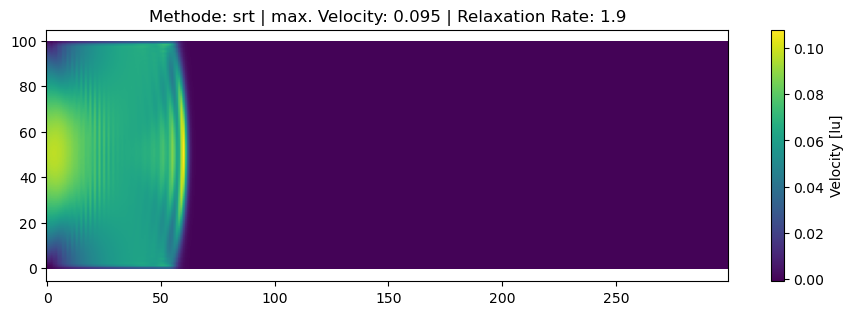

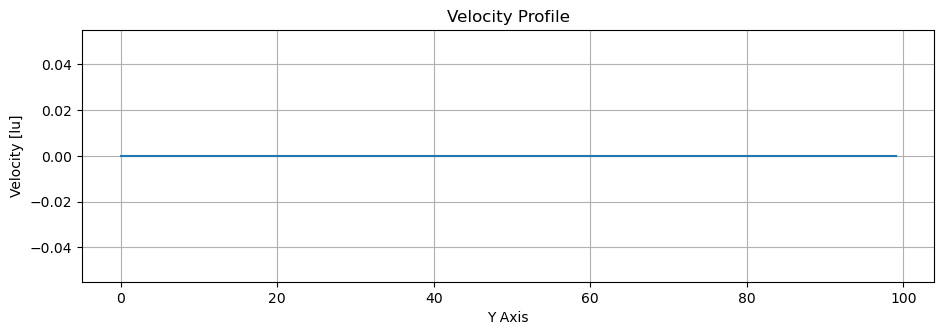

In [6]:
# Definieren der Methode als String
method = 'srt'

# Erstellen eines neuen Szenarios
scenario = create_channel(domain_size=(length, height), 
                          u_max=maximal_velocity,  
                          method=method, 
                          relaxation_rate=relaxation_rate,
                          optimization=optimization)

# Simulation für n iterationen starten
steps = 100
scenario.run(steps)

# Ergebnis plotten
plot_velocity(scenario.velocity[:, :, 0])

So wie das Resultat aussieht, sind 100 iterationen eindeutig zu wenig um einen stabilen Luftstrom zu erzeugen. Der Plot zeigt jedoch sehr schön, wie unsere Geschwindigkeitsbedingung am Inlet sich auf den Kanal auswirkt.

Lassen wir die Simulation etwas länger laufen.

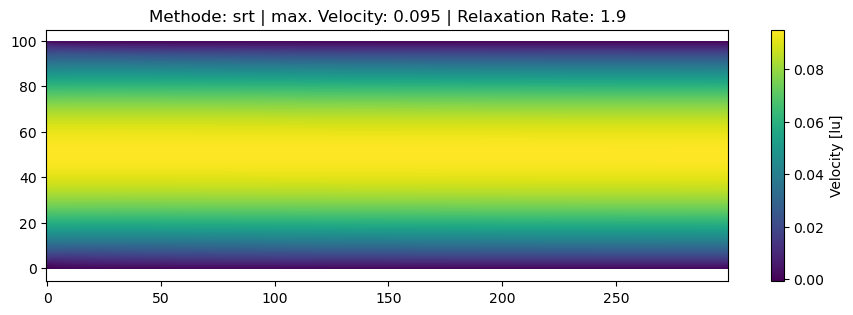

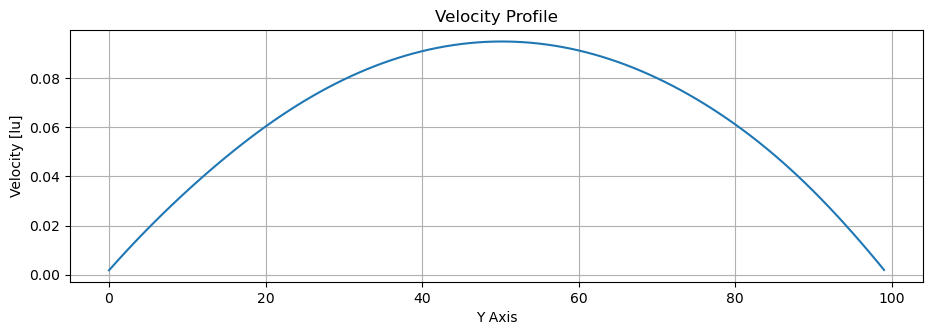

In [7]:
# Simulation für n iterationen starten
steps = 50000
scenario.run(steps)

# Ergebnis plotten
plot_velocity(scenario.velocity[:, :, 0])

Dieses Ergebnis sieht schon besser aus. Das Geschwindigkeitsprofil zeigt uns auch, dass das Medium parabolisch gegen null richtung Randstellen zugeht. Die Strömung entspricht einem Poiseuille Flow.

---

## Einfluss der Parameter <a class="anchor" id="Einfluss_der_Parameter"></a>

Nachdem wir unsere erste Simulation zum laufen gebracht haben, können wir ein bisschen mit den Einstellungen experimentieren.
Was die Parameter `length`, `height` und `maximal_velocity` für eine Auswirkung haben, ist sehr wahrscheinlich klar. Änderungen in `relaxation_rate` und `method` sind jedoch weniger gut vorstellbar.

### Relaxation Zeit $\tau$ <a class="anchor" id="Relaxation_Zeit_2"></a>

Die Relaxation Zeit definiert, wie dick- oder dünnflüssig ein Medium ist. Je grösser der Wert, dest dünnflüssiger wird das Medium. Der stabile Bereich liegt zwischen einem Wert von 0.5 und 2. Im folgenden Code Block können die zwei Relaxations Zeiten verändert und verglichen werden. Für die Gegenüberstellung wird ein Hindernis eingebaut, damit der Effekt des Parameter besser sichtbar wird. Auf das Einbauen und erstellen von Hindernissen wird in einem späteren Kapitel eingegangen.

In [8]:
from lbmpy.session import *
from lbmpy.boundaries import NoSlip

C:\Users\studadm\anaconda3\lib\site-packages\pystencils\gpucuda\cudajit.py:73: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The -std=c++11 flag is not supported with the configured host compiler. Flag will be ignored.
kernel.cu

  mod = SourceModule(code, options=nvcc_options, include_dirs=[


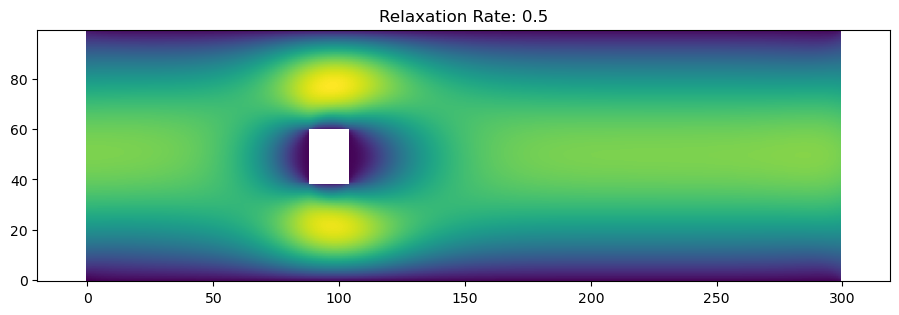

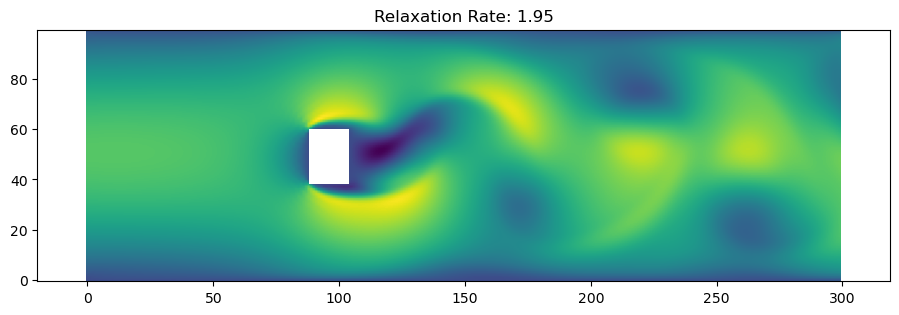

In [9]:
# Relaxations Zeiten
first_relaxation_rate = 0.5
second_relaxation_rate = 1.95

# Erstellen der Szenarien
first_scenario = create_channel(domain_size=(300, 100), 
                                u_max=0.05,  
                                method='srt', 
                                relaxation_rate=first_relaxation_rate,
                                optimization=optimization)

second_scenario = create_channel(domain_size=(300, 100), 
                                 u_max=0.05,  
                                 method='srt', 
                                 relaxation_rate=second_relaxation_rate,
                                optimization=optimization)

# Hindernisse hinzufügen
first_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.35, 0.4:0.6])
second_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.35, 0.4:0.6])

# Simulation für n iterationen starten
steps = 20000
first_scenario.run(steps)
second_scenario.run(steps)

# Ergebnisse plotten
plt.figure(figsize=(11, height/(length/10)), dpi=100)
plt.title("Relaxation Rate: {0}".format(first_relaxation_rate))
plt.scalar_field(first_scenario.velocity[:, :, 0])

plt.figure(figsize=(11, height/(length/10)), dpi=100)
plt.title("Relaxation Rate: {0}".format(second_relaxation_rate))
plt.scalar_field(second_scenario.velocity[:, :, 0])

### Methode <a class="anchor" id="Methode"></a>
 
Für die Gegenüberstellung der Methoden verwenden wir das gleiche Prinzip.

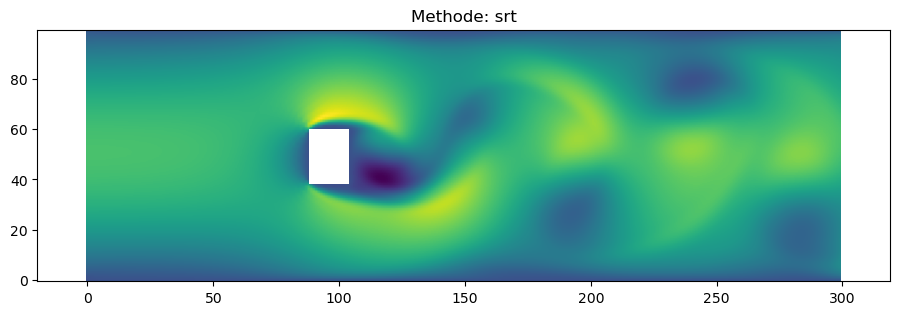

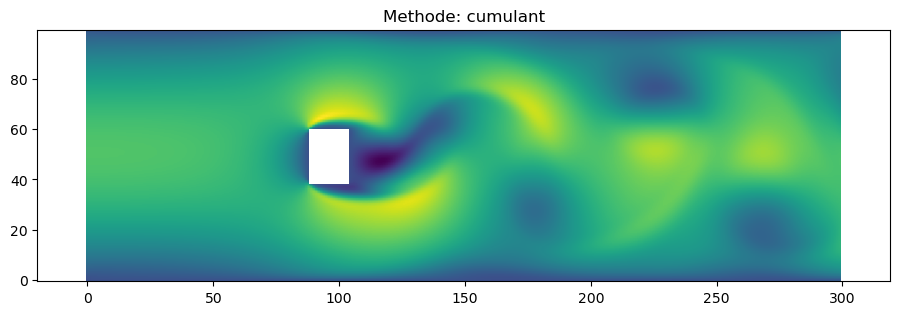

In [10]:
# Relaxations Zeiten
first_method = 'srt'
second_method = 'cumulant'

# Erstellen der Szenarien
first_scenario = create_channel(domain_size=(300, 100), 
                                u_max=0.05,  
                                method=first_method, 
                                relaxation_rate=1.95,
                                optimization=optimization)

second_scenario = create_channel(domain_size=(300, 100), 
                                 u_max=0.05,  
                                 method=second_method, 
                                 relaxation_rate=1.95,
                                 optimization=optimization)

# Hindernisse hinzufügen
first_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.35, 0.4:0.6])
second_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.35, 0.4:0.6])

# Simulation für n iterationen starten
steps = 100000
first_scenario.run(steps)
second_scenario.run(steps)

# Ergebnisse plotten
plt.figure(figsize=(11, height/(length/10)), dpi=100)
plt.title("Methode: {0}".format(first_method))
plt.scalar_field(first_scenario.velocity[:, :, 0])

plt.figure(figsize=(11, height/(length/10)), dpi=100)
plt.title("Methode: {0}".format(second_method))
plt.scalar_field(second_scenario.velocity[:, :, 0])

Bei den Methoden ist der Unterschied nicht so klar. Das liegt daran, dass die gleichen Simulationen mit identischen Parameter auf unterschiedliche Arten berechnet wurden. Grundsätzlich kann man sagen, dass die cumulant Methode komplexer und besser für die korrekte Berechnung von Turbulenz ist. Beim Ausführen dieses Code Blocks ist dir wahrscheinlich auch aufgefallen, dass die Rechenzeit ein bisschen länger war im Vergleich zu den Entspannungsraten. 

---

## Physikalische Parameter <a class="anchor" id="Physikalische_Parameter"></a>

Die Werte im Lattice Raum sagen können ein wenig abstrakt wirken. Ausserdem ist es sich schwer vorzustellen, was zum Beispiel eine Geschwindigkeit von 0.05 mit einer Relaxationszeit von 1.9 heisst. Aus diesem Grund wechseln wir in diesem Kapitel zu physikalischen Werten, welche dann in den Lattice Raum konvertiert werden.

### Eingabewerte <a class="anchor" id="Eingabewerte"></a>

Sehen wir zuerst einmal, welche Werte wir selber bestimmen können.

<br>

<img src="pic/Physical_Domain_Size.png" width="400" align="left"/>


| Eingabewerte            | Einheiten            |
| :------------------     | -------------------: |
| Länge des Kanals        | $m$                  |
| Höhe des Kanals         | $m$                  |
| Länge über n Zellen     | $m$                  |
| Anzahl Zellen           |                      |
| Geschwindigkeit         | $\Large\frac{m}{s}$  |
| Kinematische Viskosität | $\Large\frac{m^2}{s}$| 

#### Grösse des Kanals

Die Grösse des Kanals kann mit drei phsyikalischen und einer Lattice Raum Grösse definiert werden. Die Länge und Höhe des Kanals werden in Meter angegeben. Damit unser Simulationsraum erstellt werden kann, benötigen wir noch eine Aussage, wie gross die Distanz zwischen den Zellen ist. Diesen Parameter definieren wir anhand einer Länge in Meter, welche der Länge über n Zellen entspricht. Der Wert dieser Länge und die Anzahl an Zellen können von uns definiert werden. Diese Definition bietet uns eine Feinjustierung der Auflösung für die Simulation. 

#### Geschwindigkeit

Die Geschwindigkeit bezieht sich wieder auf das Zentrum am Inlet. Die Geschwindigkeit wird dann parabolisch angelegt.

#### Kinematische Viskosität

Die kinematische Viskosität kann aus Tabellen entnommen werden. Wir verwenden für den weiteren Verlauf den [kinematischen Viskositätswert](https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm) für Luft bei 20°C.


### Konvertierung <a class="anchor" id="Konvertierung"></a>

Die Konvertierung vom physikalischen in den Lattice Raum übernimmt `lbmpy` für uns. Wir haben jedoch eine Auswahl von drei möglichen Methoden. Bei jeder Methode wird ein Wert im Lattice Raum fixiert, damit die anderen Werte davon abgeleitet werden können. Die drei fixierten Werte sind:

    Fixierte Lattice Geschwindigkeit
    Fixierte Lattice Relaxation Zeit
    Fixierter Lattice Zeitschritt
    
Versuchen wir die Konvertierung mit den folgenden Werten durchzuführen.

In [11]:
from lbmpy.session import *
from lbmpy.parameterization import Scaling
from lbmpy.boundaries import NoSlip

In [12]:
# Grösse des Kanals
length           = 0.5  # [m]
height           = 0.2  # [m]
length_per_cells = 0.01 # [m]
number_of_cells  = 20

# Geschwindigkeit
velocity = 0.2

# Kinematische Viskosität
kinematic_viscosity = 1.516e-5

In [13]:
# lbmpy Skalierungs Klasse
sc = Scaling(physical_length=length_per_cells, 
             physical_velocity=velocity, 
             kinematic_viscosity=kinematic_viscosity, 
             cells_per_length=number_of_cells)

# Berechnung der Länge und Höhe
lattice_length = round(length / (length_per_cells / number_of_cells))
lattice_height = round(height / (length_per_cells / number_of_cells))


# Konvertierung mit fixierter lattice Geschwindigkeit
fixed_lattice_velocity = 0.1
scaling_result_vel = sc.fixed_lattice_velocity_scaling(fixed_lattice_velocity)


# Konvertierung mit fixierter lattice Relaxation Zeit
fixed_lattice_relaxation_rate = 1.9
scaling_result_rel = sc.diffusive_scaling(fixed_lattice_relaxation_rate)


# Konvertierung mit fixiertem lattice Zeitschritt
fixed_lattice_timestep = 0.001
scaling_result_time = sc.acoustic_scaling(fixed_lattice_timestep)

In [14]:
print("Grösse des Kanals im Lattice Raum\nLänge: {0} / Höhe: {1}\n".format(lattice_length, lattice_height))

print("Konvertierte Grössen:")
print("-----------------------------------------------")

print("Lattice Geschwindigkeit:  ¦       {0}  ¦ Fixiert".format(fixed_lattice_velocity))
print("Lattice Relaxation Zeit:  ¦  {0: 0.5f}  ¦".format(scaling_result_vel.relaxation_rate))
print("Lattice Timestep:         ¦  {0: 0.5f}  ¦\n".format(scaling_result_vel.dt))

print("-----------------------------------------------")

print("Lattice Geschwindigkeit:  ¦  {0: 0.5f}  ¦".format(scaling_result_rel.lattice_velocity))
print("Lattice Relaxation Zeit:  ¦       {0}  ¦ Fixiert".format(fixed_lattice_relaxation_rate))
print("Lattice Timestep:         ¦  {0: 0.5f}  ¦\n".format(scaling_result_rel.dt))

print("-----------------------------------------------")

print("Lattice Geschwindigkeit:  ¦  {0: 0.5f}  ¦".format(scaling_result_rel.lattice_velocity))
print("Lattice Relaxation Zeit:  ¦  {0: 0.5f}  ¦".format(scaling_result_vel.relaxation_rate))
print("Lattice Timestep:         ¦     {0}  ¦ Fixiert".format(fixed_lattice_timestep))

Grösse des Kanals im Lattice Raum
Länge: 1000 / Höhe: 400

Konvertierte Grössen:
-----------------------------------------------
Lattice Geschwindigkeit:  ¦       0.1  ¦ Fixiert
Lattice Relaxation Zeit:  ¦   1.83325  ¦
Lattice Timestep:         ¦   0.00025  ¦

-----------------------------------------------
Lattice Geschwindigkeit:  ¦   0.05786  ¦
Lattice Relaxation Zeit:  ¦       1.9  ¦ Fixiert
Lattice Timestep:         ¦   0.00014  ¦

-----------------------------------------------
Lattice Geschwindigkeit:  ¦   0.05786  ¦
Lattice Relaxation Zeit:  ¦   1.83325  ¦
Lattice Timestep:         ¦     0.001  ¦ Fixiert


Das Ergebnis unserer Konvertierung gibt uns die Lattice Werte, welche unseren physikalischen Grössen representieren. Wenn wir so vorgehen, können wir eine Simulation erstellen, deren Resultate verständlicher für uns sind.

---

**Wichtig:**

Bei der Konvertierung ist sehr darauf zu achten, dass die Lattice Werte der Geschwindigkeit und der Relaxationszeit ihre Grenzwerte nicht überschreiten.

Lattice Geschwindigkeit: 0 - 0.1<br>
Lattice Relaxation Zeit: 0.5 - 2

*Bemerkung: Die Relaxation Zeit wird nie über 2 gehen. Ein Wert, der sehr nahe an 2 herankommt, ist aber zu vermeiden.*

---

Im nächsten Abschnitt vergleichen wir wieder zwei Simulationen. Beide haben die gleichen Dimensionen für den Kanal. Die Geschwindigkeit setzen wir auch für beide gleich. Das einzige, was geändert wird, ist die kinematische Viskosität. Als Beispiel nehmen wir aus einer [Tabelle](https://www.flottweg.com/de/wiki/trenntechnik/dynamische-viskositaet/) die kinematische Viskosität für Wasser ($1.004 \cdot 10^{-6}$) und für Olivenöl ($8.9 \cdot 10^{-5}$)

In [15]:
# Simulationsparameter für Nummer 1
length_1              = 0.0004    # [m]
height_1              = 0.0001    # [m]
length_per_cells_1    = 0.0001   # [m]
number_of_cells_1     = 100
velocity_1            = 5      # [m/s]
kinematic_viscosity_1 = 1.004e-6 # [m^2/s]  Wasser

# Simulationsparameter für Nummer 2
length_2              = 0.0004    # [m]
height_2              = 0.0001    # [m]
length_per_cells_2    = 0.0001   # [m]
number_of_cells_2     = 100
velocity_2            = 5      # [m/s]
kinematic_viscosity_2 = 8.9e-5   # [m^2/s]  Olivenöl


# lbmpy Skalierungs Klasse
sc_1 = Scaling(physical_length=length_per_cells_1, 
               physical_velocity=velocity_1, 
               kinematic_viscosity=kinematic_viscosity_1, 
               cells_per_length=number_of_cells_1)

sc_2 = Scaling(physical_length=length_per_cells_2, 
               physical_velocity=velocity_2, 
               kinematic_viscosity=kinematic_viscosity_2, 
               cells_per_length=number_of_cells_2)


# Berechnung der Länge und Höhe
lattice_length_1 = round(length_1 / (length_per_cells_1 / number_of_cells_1))
lattice_height_1 = round(height_1 / (length_per_cells_1 / number_of_cells_1))

lattice_length_2 = round(length_2 / (length_per_cells_2 / number_of_cells_2))
lattice_height_2 = round(height_2 / (length_per_cells_2 / number_of_cells_2))


# Konvertierung mit fixierter lattice Relaxation Zeit
fixed_lattice_relaxation_rate = 1.9

scaling_result_1 = sc_1.diffusive_scaling(fixed_lattice_relaxation_rate)
print("Simulation 1\nlx: {0}\nly: {1}\n{2}\n".format(lattice_length_1, lattice_height_1, scaling_result_1))

scaling_result_2 = sc_2.diffusive_scaling(fixed_lattice_relaxation_rate)
print("Simulation 2\nlx: {0}\nly: {1}\n{2}\n".format(lattice_length_2, lattice_height_2, scaling_result_2))

Simulation 1
lx: 400
ly: 100
DiffusiveScalingResult(dt=8.736981896973516e-09, lattice_velocity=0.043684909484867585)

Simulation 2
lx: 400
ly: 100
DiffusiveScalingResult(dt=9.856100926473496e-11, lattice_velocity=0.0004928050463236747)



Beim Experimentieren mit den Werten sollte bei diesem Schritt immer kontrolliert werden, dass die Lattice Geschwindigkeit nicht grösser als 0.1 wird. Die Grösse des Kanals sollte auch eher unter 1000 Zellen bleiben, da die Berechnung sonst recht lange dauert.

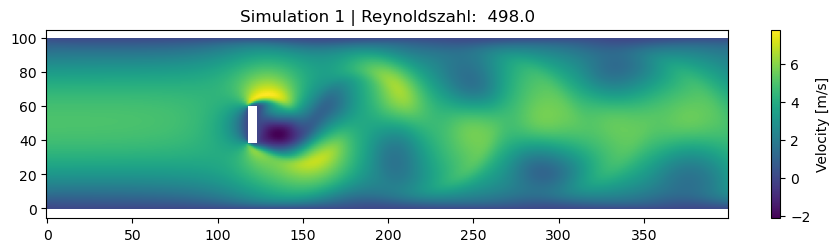

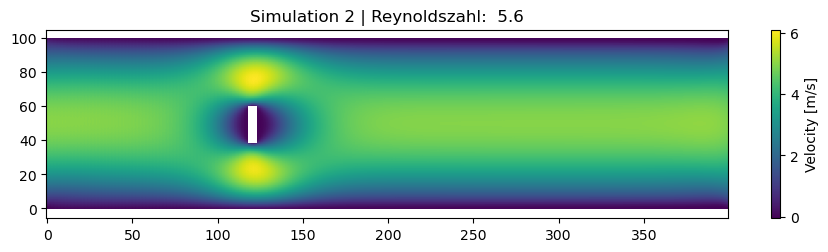

In [16]:
# Erstellen der Szenarien
first_scenario = create_channel(domain_size=(lattice_length_1, lattice_height_1), 
                                u_max=scaling_result_1.lattice_velocity,  
                                method='srt', 
                                relaxation_rate=fixed_lattice_relaxation_rate,
                                optimization=optimization)

second_scenario = create_channel(domain_size=(lattice_length_2, lattice_height_2), 
                                u_max=scaling_result_2.lattice_velocity,  
                                method='srt', 
                                relaxation_rate=fixed_lattice_relaxation_rate,
                                optimization=optimization)

# Hindernisse hinzufügen
first_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.31, 0.4:0.6])
second_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.31, 0.4:0.6])

# Simulation für n iterationen starten
steps = 50000
first_scenario.run(steps)
second_scenario.run(steps)

# Ergebnisse plotten
plt.figure(figsize=(11, lattice_height_1/(lattice_length_1/10)), dpi=100)
plt.title("Simulation 1 | Reynoldszahl: {0: 0.1f}".format(sc_1.reynolds_number))
Cu =  velocity_1 / scaling_result_1.lattice_velocity
plt.scalar_field(first_scenario.velocity[:, :, 0] * Cu)
plt.colorbar().set_label("Velocity [m/s]")

plt.figure(figsize=(11, lattice_height_2/(lattice_length_2/10)), dpi=100)
plt.title("Simulation 2 | Reynoldszahl: {0: 0.1f}".format(sc_2.reynolds_number))
Cu =  velocity_2 / scaling_result_2.lattice_velocity
plt.scalar_field(second_scenario.velocity[:, :, 0] * Cu)
plt.colorbar().set_label("Velocity [m/s]")

## Hindernisse <a class="anchor" id="Hindernisse"></a>

Ein leerer Kanal ist nicht gerade spannend. Spannend wird es, sobald ein Objekt den Fluss behindert. In diesem Kapitel schauen wir uns verschiedene Möglichkeiten der Hindernisgenerierung an. Um eine spezifische Form zu generieren, ist ein bisschen Kreativität gefragt. 

Um ein Hindernis in unserem Szenarion zu platzieren, müssen wir der `boundarie_handling` Komponente Instruktionen geben. Mit der Funktion `set_boundary()` können wir das Verhalten und die Position unseres Hindernis bestimmen. Für das Verhalten beschränken wir uns auf eine NoSlip Bedingung. Das bedeutet, dass die Zellen, welche direkt am Hindernis anliegen, keine Flussgeschwindigkeit parallel zur Hinderniszelle haben. Dieses Verhalten wird durch eine *BounceBack* Bedingung ausgelöst. Wir sehen dieses Verhalten auch an den Kanalwänden. 

Um zu sehen, wie unsere Hindernisse im Kanal generiert wurden, können wir von `boundarie_handling` die Umgebungsinformationen plotten.

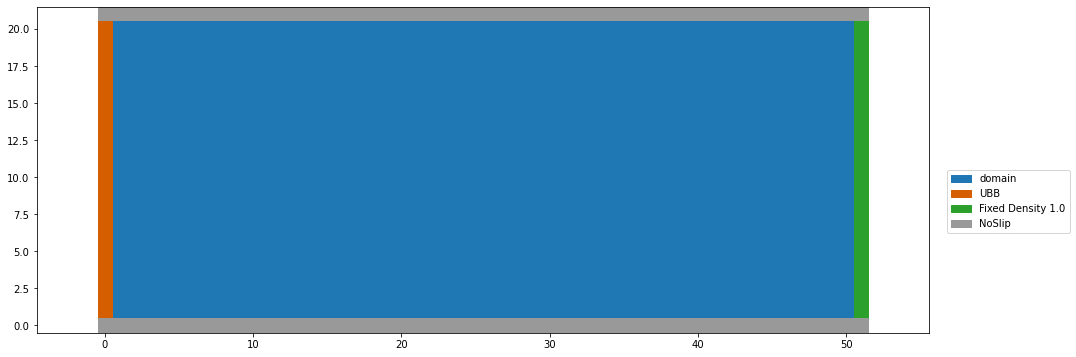

In [17]:
boundary_scenario = create_channel(domain_size=(50, 20), 
                                   u_max=0.05,  
                                   method='cumulant', 
                                   relaxation_rate=1.8,
                                   optimization=optimization)

plt.boundary_handling(boundary_scenario.boundary_handling)

Der Plot zeigt uns die gesetzten Bedingungen für jede Zelle. Inlet und Outlet sind anderst als eine normale Zelle wegen unserer Geschwindigkeitsbedingung.

### Rechteck <a class="anchor" id="Rechteck"></a>

Die einfachste Möglichkeit, ein Hindernis zu erstellen, ist eine Rechteckmaske zu generieren. Dafür übergeben wir der `set_boundary` Funktion folgende zwei Variablen:

    NoSlip()
    make_slice[x1:x2, y1:y2]
    
Die Position des Rechtecks in `make_slice` kann auf zwei verschiedene Arten angegeben werden.

    Integer Zahlen als Koordinatenangabe
    Float Zahlen als Verhältnisangabe
    
Mit der Koordinatenangabe kann ein Bereich als $x$ und $y$-Koordinaten übergeben werden. Die Verhältnisangabe akzeptiert `float` Zahlen im Bereich von 0.0 und 1.0. Die Zahl 0.5 für den $x$ und $y$-Wert würde eine Zelle in der Mitte des Kanals setzen.  

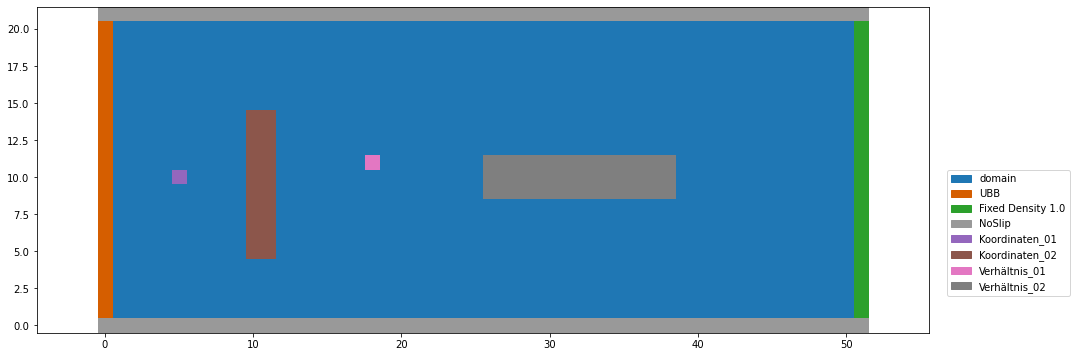

In [18]:
boundary_scenario.boundary_handling.set_boundary(NoSlip("Koordinaten_01"), make_slice[5, 10])
boundary_scenario.boundary_handling.set_boundary(NoSlip("Koordinaten_02"), make_slice[10:12, 5:15])

boundary_scenario.boundary_handling.set_boundary(NoSlip("Verhältnis_01"), make_slice[0.35, 0.5])
boundary_scenario.boundary_handling.set_boundary(NoSlip("Verhältnis_02"), make_slice[0.5:0.75, 0.45:0.55])

plt.boundary_handling(boundary_scenario.boundary_handling)

Die `NoSlip()` Funktion kann mit oder ohne String übergeben werden. Der String ist als Beschriftung zu verstehen. 

Die gesetzten Hinderniszellen bleiben für das Szenario erhalten. Um die Hindernisse wieder zu normalen Domainzellen zu konvertieren, kann der `set_boundary()` Methode ein String `"domain"` anstatt `NoSlip()` übergeben werden. Wenn alle gesetzten Hindernisse gelöscht werden sollen, ist das Erstellen eines neuen Szenarios der schnellste Weg.

### Maske <a class="anchor" id="Maske"></a>

Eine weitere Möglichkeit ist das Übergeben einer Boolean-Maske. Dafür kann `make_slice` mit einer selbst definierten Funktion ersetzt werden. Die Variable dafür heisst `mask_callback`. Die selbst erstellte Funktion muss zwei Arrays als Input aufnehmen, welche von `lbmpy` als $x$ und $y$ definiert sind. Als Rückgabewert wird eine Matrix mit der Grösse `(länge_Kanal + 2, höhe_Kanal + 2)` übergeben, welche `True` an den Hinderniszellen gesetzt hat. Die zusätzliche Grösse von 2 in $x$- und $y$- Richtung kommt von den Grenzzellen und dem In- und Outlet.

Der folgende Block zeigt uns, wie die vom `boundary_handling` übergebenen Arrays aufgebaut sind.

In [19]:
def check_mask_input(x, y):
    print("x Value (Shape of Array {0}):\n{1}".format(x.shape, x))
    print("\ny Value (Shape of Array {0}):\n{1}".format(y.shape, y))
    return None

boundary_scenario.boundary_handling.set_boundary("domain", mask_callback=check_mask_input)

x Value (Shape of Array (52, 22)):
[[-0.5 -0.5 -0.5 ... -0.5 -0.5 -0.5]
 [ 0.5  0.5  0.5 ...  0.5  0.5  0.5]
 [ 1.5  1.5  1.5 ...  1.5  1.5  1.5]
 ...
 [48.5 48.5 48.5 ... 48.5 48.5 48.5]
 [49.5 49.5 49.5 ... 49.5 49.5 49.5]
 [50.5 50.5 50.5 ... 50.5 50.5 50.5]]

y Value (Shape of Array (52, 22)):
[[-0.5  0.5  1.5 ... 18.5 19.5 20.5]
 [-0.5  0.5  1.5 ... 18.5 19.5 20.5]
 [-0.5  0.5  1.5 ... 18.5 19.5 20.5]
 ...
 [-0.5  0.5  1.5 ... 18.5 19.5 20.5]
 [-0.5  0.5  1.5 ... 18.5 19.5 20.5]
 [-0.5  0.5  1.5 ... 18.5 19.5 20.5]]


1

Mit diesem Wissen können wir nun zwischen zwei möglichen Varianten der Maskenerstellung auswählen.

Die erste Methode ist ein nicht so intuitiv, dafür ist sie hervorragend geeignet für das Erstellen von runden Objekte. Dabei werden die gegebenen Inputarrays in einer Funktion verwendet. Ganz simpel erklärt kann zum Beispiel die Koordinatenfunktion eines Kreises

$(x-x_M)^2 + (y-y_M)^2 = r^2$

direkt als Rückgabebedingung in einer Funktion integriert werden.

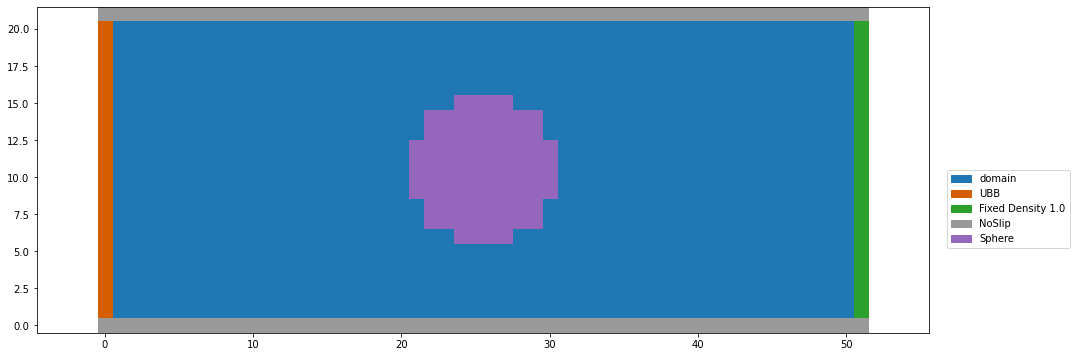

In [20]:
boundary_scenario = create_channel(domain_size=(50, 20), 
                                   u_max=0.05,  
                                   method='cumulant', 
                                   relaxation_rate=1.8,
                                   optimization=optimization)


# Maskenfunktion
def set_sphere(x, y):
    
    # Die Grösse des Kanals
    shape = boundary_scenario.domain_size
    
    # Den Mittelpunkt des Kreises setzen
    mid = (0.5 * shape[0], 0.5 * shape[1])
    
    # Den Radius des Kreises definieren
    radius = 5
    
    # Koordinatenfunktion des Kreises
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

# Hier wird die Maskenfunktion eingebaut
boundary_scenario.boundary_handling.set_boundary(NoSlip("Sphere"), mask_callback=set_sphere)
plt.boundary_handling(boundary_scenario.boundary_handling)

Die zweite Möglichkeit ignoriert die Inputarrays und erstellt selbständig eine Booleanmatrix in der grösse des Kanals. Diese Möglichkeit ist grundsätzlich einfacher zu verstehen, benötigt aber ein bisschen mehr Code. Zusätzlich können wir aus diversen vorberechneten Dingen eine Maske erstellen und diese übergeben.

Das [`airfoils`](https://pypi.org/project/airfoils/) Packet kann für uns ein [NACA](https://de.wikipedia.org/wiki/NACA-Profile) Profil generieren, welches uns die $y$ Koordinaten für einen beliebigen Punkt $x$ zwischen 0 und 1 ausgeben kann.

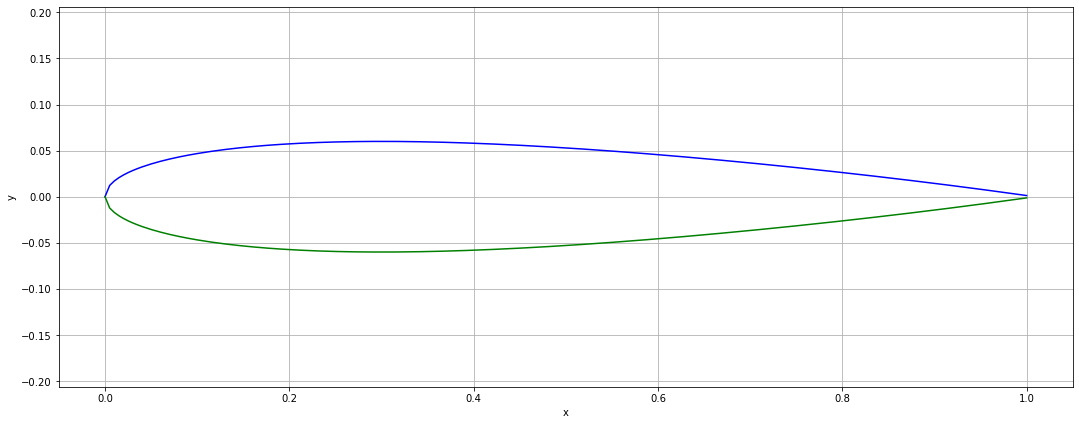

In [21]:
from airfoils import Airfoil

# Mit dem airfoils Paket erstellen wir ein 0012 NACA Profil
foil = Airfoil.NACA4("0012")
foil.plot()

Der nächste Block wirkt wahrscheinlich abschreckend, jedoch ist es nicht nötig, die Aufbereitung des Flügelprofils im Detail zu verstehen. Die Aufbereitung kann wahrscheinlich optimiert werden. In diesem Fall wird über das untere und obere Profil iteriert, und die Werte der Punkte mit künstlich generierten Inputarrays (welche den Arrays der `mask_callback` Variable entsprechen) verglichen. Da unsere Profilwerte nicht auf einem Gitter mit einheitlichen Abständen liegen, wird der Index, der am nächsten unserem Profilwert entspricht, in der Maske auf True gesetzt.

C:\Users\studadm\anaconda3\lib\site-packages\pystencils\gpucuda\cudajit.py:73: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The -std=c++11 flag is not supported with the configured host compiler. Flag will be ignored.
kernel.cu

  mod = SourceModule(code, options=nvcc_options, include_dirs=[


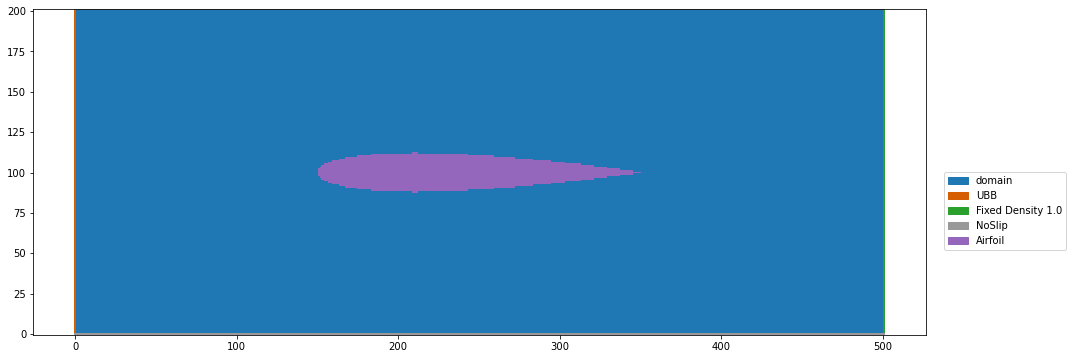

In [22]:
boundary_scenario = create_channel(domain_size=(500, 200), 
                                   u_max=0.05,  
                                   method='cumulant', 
                                   relaxation_rate=1.8,
                                   optimization=optimization)


# X Koordinaten für Airfoil mit Auflösung 0.001
airfoil_x = np.arange(0, 1.001, 0.001, dtype=np.float64)

# Y Koordinaten für unteres und oberes Profil 
airfoil_y_lower = np.array(foil.y_lower(airfoil_x), dtype=np.float64)
airfoil_y_upper = np.array(foil.y_upper(airfoil_x), dtype=np.float64)

# X und Y kombinieren und das Profil um den Wert 200 vergrössern
airfoil_upper = np.stack((airfoil_x - 0.5, airfoil_y_upper)) * 200
airfoil_lower = np.stack((airfoil_x - 0.5, airfoil_y_lower)) * 200

# Verschieben des Profils an bevorzugten Punkt
shape = boundary_scenario.domain_size
airfoil_upper[0, :] += 0.5 * shape[0]
airfoil_upper[1, :] += 0.5 * shape[1]
airfoil_lower[0, :] += 0.5 * shape[0]
airfoil_lower[1, :] += 0.5 * shape[1]

# Maske erstellen in der Grösse der Inputarrays
mask = np.zeros((shape[0] + 2, shape[1] + 2), dtype=bool)

# Die Inputarrays werden künstlich von uns erstellt, um einen Vergleich zu ermöglichen
x = np.ones((shape[0] + 2, shape[1] + 2))
y = np.ones((shape[0] + 2, shape[1] + 2))

inc = -0.5
for i in range(shape[0] + 2):
    x[i, :] *= inc
    inc += 1

inc = -0.5
for i in range(shape[1] + 2):
    y[:, i] *= inc
    inc += 1

# In diesem for loop setzen wir die Indices, welche am nächsten unseren Profilwerten entsprechen zu True
for j, value_x in zip(range(len(airfoil_upper[0])), airfoil_upper[0, :]):

    # Search for the index in x, which is closest to the current x-value in our profile
    idx_x = np.abs((x[:, 0] - value_x)).argmin()

    # Get the corresponding y-values for our current x-value from the profile
    value_y_upper = airfoil_upper[1, j]
    value_y_lower = airfoil_lower[1, j]

    # Search for the indices in y, which are closest to the current y-values in our profile
    idx_y_upper = np.abs((y[0, :] - value_y_upper)).argmin()
    idx_y_lower = np.abs((y[0, :] - value_y_lower)).argmin()

    # update the mask
    mask[idx_x, idx_y_lower:idx_y_upper] = True
    
    
# Maskenfunktion
def set_airfoil(x, y):
    return mask


boundary_scenario.boundary_handling.set_boundary(NoSlip("Airfoil"), mask_callback=set_airfoil)
plt.boundary_handling(boundary_scenario.boundary_handling)

Et Voilà! Wir haben erfolgreich ein Flügelprofil als Hindernis eingebaut.

Zum Abschluss dieses Notebooks erstellen wir ein Szenario mit diversen Hindernissen.

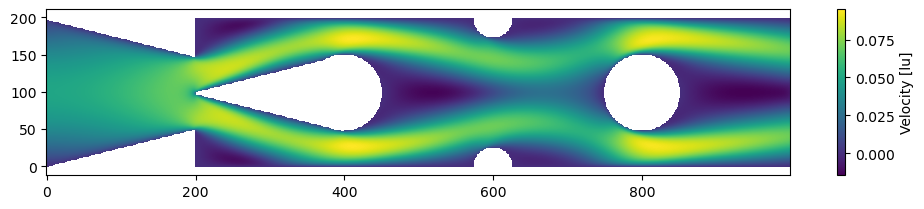

In [23]:
boundary_scenario = create_channel(domain_size=(1000, 200), 
                                   u_max=0.05,  
                                   method='cumulant', 
                                   relaxation_rate=1.6,
                                   optimization=optimization)

for i in range(200):
    boundary_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[i, 0:round(50*i/200)])
    boundary_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[i, round(200 - (50*i/200)):200])
    
    boundary_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[i+200, 100:round(100 + (50*i/200))])
    boundary_scenario.boundary_handling.set_boundary(NoSlip(), make_slice[i+200, round(100 - (50*i/200)):100])

def set_sphere_01(x, y):
    shape = boundary_scenario.domain_size
    mid = (400, 0.5 * shape[1])
    radius = 50
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

def set_sphere_02(x, y):
    shape = boundary_scenario.domain_size
    mid = (600, 0)
    radius = 25
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

def set_sphere_03(x, y):
    shape = boundary_scenario.domain_size
    mid = (600, shape[1])
    radius = 25
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

def set_sphere_04(x, y):
    shape = boundary_scenario.domain_size
    mid = (800, 0.5 * shape[1])
    radius = 50
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

boundary_scenario.boundary_handling.set_boundary(NoSlip(), mask_callback=set_sphere_01)
boundary_scenario.boundary_handling.set_boundary(NoSlip(), mask_callback=set_sphere_02)
boundary_scenario.boundary_handling.set_boundary(NoSlip(), mask_callback=set_sphere_03)
boundary_scenario.boundary_handling.set_boundary(NoSlip(), mask_callback=set_sphere_04)

boundary_scenario.run(100000)
plt.figure(figsize=(12, 200/(1000/11)), dpi=100)
plt.scalar_field(boundary_scenario.velocity[:, :, 0])
plt.colorbar().set_label("Velocity [lu]")

Gratulation! Im nächsten Notebook gehen wir mehr auf die Flügelprofile und das Auswerten der entstehenden Lift und Drag Kräfte ein.

---

<div style=”text-align: left”> Bachelorarbeit, Lattice Boltzmann Simulation

<img src="pic/ost_logo.jpg" width="350" align="right"/>
<br> FS 2021 <br>  <a href=mailto:remo.haenggi@hotmail.ch> Student: Remo Hänggi </a> <a href=mailto:christoph.wuersch@ost.ch>
<br>
Advisor: Prof. Dr. Christoph Würsch </a </div>